In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image
import time
import pandas as pd
import os
import csv
import PIL.ImageDraw as ImageDraw,PIL.Image as Image, PIL.ImageShow as ImageShow 
from sklearn.utils import shuffle
import pickle

First, I converted all training images to B&W and processed them into one-row arrays of pixels. I then exported these vectors into  'pixels.csv' file

In [2]:
def load_data(dirr):
    l=[]
    for filename in sorted(os.listdir(dirr)):
        if filename[-4:]!='.png':
            continue
        img1 = Image.open(dirr + filename,'r')
        img1 = img1.convert('L')
        pixels = np.array(np.asarray(img1), np.uint8).reshape(img1.size[1], img1.size[0])
        l.append(pixels) 
    return l

l = load_data('Images/')
out = np.concatenate(l).ravel()
out1 = out.reshape(200,7500)

Then I created training set and scaled training data

In [3]:
df = pd.read_csv('data/training.csv')
df11 = pd.read_csv('data/pixels.csv')
df = df.sort_values(['Image'])
df = df.reset_index(drop=True)
df = df.join(df11)
df[' pixels'] = df[' pixels'].apply(lambda im: np.fromstring(im, sep=' '))
df = df.dropna()
X = np.vstack(df[' pixels'].values)/225  # scale pixel values to [0, 1]
X = X.astype(np.float32)
X = X.reshape(-1, 75, 100, 1) # return each images as 75 x 100 x 1
y = df[df.columns[1:-2]].values
y = 2/83*(y-4)-1
# scale target coordinates to [-1, 1]
y = y.astype(np.float32)

In [4]:
X_train, y_train = X, y
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

X_train.shape == (200, 75, 100, 1)
y_train.shape == (200, 12); y_train.min == -0.984; y_train.max == 1.036


Then I visualized my training data to be sure that the pixel-arrays are done right

In [5]:
def plot_data(img, landmarks, axis):
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    # undo the normalization
    landmarks1 = 0.5 * (landmarks + 1) * 83+4
    # Plot the keypoints
    axis.scatter(landmarks1[0::2],landmarks1[1::2],marker='o',c='c',s=175)

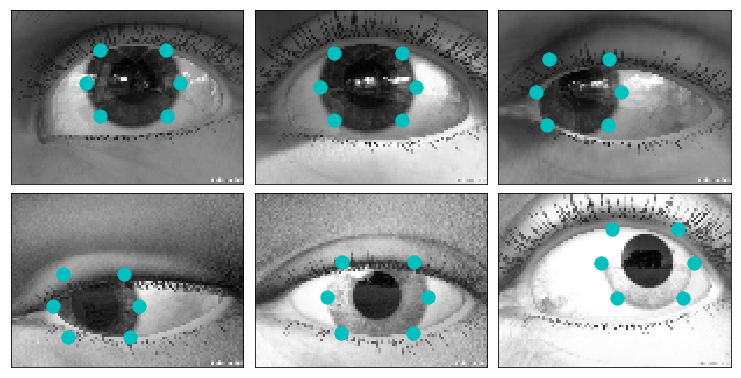

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,7):
    ax = fig.add_subplot(3, 3, i, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

### MODEL

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(75,100, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 98, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 10, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 8, 128)         73856     
__________

Training the model

In [9]:
hist = History()
epochs = 50
batch_size = 64

checkpointer = ModelCheckpoint(filepath='weights.final_2.hdf5', 
                               verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

hist_final = model.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)


model.save('my_model_final.h5')

Train on 160 samples, validate on 40 samples
Epoch 1/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1769 - acc: 0.5375 - val_loss: 0.1264 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.12643, saving model to weights.final_2.hdf5
Epoch 2/50
160/160 [==============================] - 1s 7ms/step - loss: 0.0965 - acc: 0.8063 - val_loss: 0.0781 - val_acc: 0.9000

Epoch 00002: val_loss improved from 0.12643 to 0.07814, saving model to weights.final_2.hdf5
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 0.0860 - acc: 0.6937 - val_loss: 0.0730 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.07814 to 0.07297, saving model to weights.final_2.hdf5
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: 0.0783 - acc: 0.8000 - val_loss: 0.0783 - val_acc: 0.9000

Epoch 00004: val_loss did not improve
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.0724 - acc: 0.8375 - val_loss: 0.

In [10]:
model.load_weights('weights.final_2.hdf5')

Then I visualized the training and validation loss of the neural network

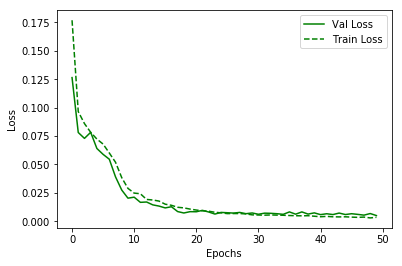

In [11]:
plt.plot(range(epochs), hist_final.history[
         'val_loss'], 'g-', label='Val Loss')
plt.plot(range(epochs), hist_final.history[
         'loss'], 'g--', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### TEST

In [12]:
l2 = load_data('test/')

In [13]:
out0 = np.concatenate(l2).ravel()
out01 = out0.reshape(3,7500)

In [14]:
X_test = np.array(out01)
X_test = np.vstack(X_test)/225 
X_test = X_test.astype(np.float32)
X_test = X_test.reshape(-1, 75, 100, 1) 

In [15]:
y_test = model.predict(X_test)

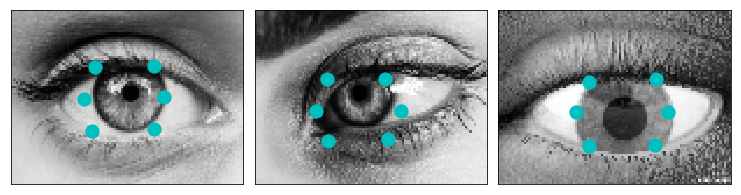

In [16]:
fig = plt.figure(figsize=(10,7.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(3):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)